<a href="https://colab.research.google.com/github/NiklasElsaesser/bug-free-fishstick/blob/main/Improved_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Version based on: [LDAPrototype](https://github.com/JonasRieger/ldaPrototype?tab=readme-ov-file)

# Setup
Installing the necessary Libraries via pip to among other things enable the setup in various development environments. The primary (default) development of the Notebook was done in Google Colab, but also occasionally run Visual Studio Code.

Notable Libraries here are:


*   gensim ->  library for topic modelling, document indexing and similarity retrieval with large corpora
*   scikit-learn -> module for machine learning built on top of SciPy




In [ ]:
%pip install pandas
%pip install numpy
%pip install --upgrade gensim
%pip install matplotlib
%pip install wordcloud
%pip install seaborn
%pip install scikit-learn
%pip install --upgrade bottleneck
%pip install pyldavis
%pip install ldatuning

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement ldatuning (from versions: none)
ERROR: No matching distribution found for ldatuning
Note: you may need to restart the kernel to use updated packages.


Here the required Moduels are imported from the previously installed libraries.

Notable Modules are:


**Gensim**
*   models.LdaModel **->** to get the functionality for LDA-Modeling
*   corpora **->** for the creation of dicitonaries and document-term matrices (corpus) for topic modeling.
*   models.CoherenceModel **->** to assess the coherence (quality) of topics and validate the results generated by the LDA models.

Rehurek, R., & Sojka, P. (2011). Gensim–python framework for vector space modelling. NLP Centre, Faculty of Informatics, Masaryk University, Brno, Czech Republic, 3(2).

**Sklearn**
* metrics.pairwise.cosine_similarity **->** computing the cosine similarity between samples in X and Y, in this case calculating vectors, document similarity and clustering text based on the content.
* feature_extraction.text.TfidfVectorizer **->**  reshaping raw text into matrix of TF-IDF features, weighing the significance of terms in a document by their relation of occurrence in the entire corpus.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830.


Other:
* matplotlib, seaborn and pyldavis for visualizations
* pandas and numpy for data manipulation and scientific computing
* random to create a seed with random parameters when running multiple ldas
* re to prepare the dataset and remove values based on regex

In [ ]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import time
import pandas as pd
from gensim.models.coherencemodel import CoherenceModel
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Datenbereinigung:
Bei dem gewählten Datensatz (siehe: https://www.kaggle.com/datasets/rmisra/news-category-dataset/data) handelt es sich um eine Auflistung von Schlagzeilen der HuffPost, welche im Zeitraum zwischen 2012 und 2022 veröffentlicht wurden. Neben den Schlagzeilen, wurden ebenfalls die Kategorien der Artikel, Kurzbeschreibungen, Verfassenden, Veröffentlichungsdaten, sowie Links zu den originalen Artikeln erhoben.
Der Datensatz umfasst 210.000 Einträge und stammt von der Website kaggle.com. Das dort angewendete Verfahren zur Datenerhebung wird nicht näher beschrieben, könnte jedoch Webscraping sein. Mit dieser Methode können relevante Informationen mittels eines Programms, wie bspw. eines Python-Skripts, von einer Website automatisiert entnommen und gespeichert werden. Die Vermutung, dass Webscraping verwendet wurde, lässt sich daraus schließen, da die Daten in einer strukturierten Form (in Kategorien geordnet) vorliegen, da dies auf ein systematisches Verfahren hindeutet. Zudem ist Webscraping eine der gängisten Methoden um Informationen von Websiten zu beschaffen und wird auf kaggle.com oft angwandt.

Da mit dem Modell der Inhalt der Daten lediglich kategorisiert und nicht bewertet werden soll, können mögliche Verzerrungen in dieser Hinsicht vernachlässigt werden (bspw. politische Ausrichtung der Texte).
Ein Problem könnte jedoch sein, dass die Kategorien nicht ausgewogen sind. Manche davon könnten häufiger im Rahmen der Artikel behandelt werden als andere, weshalb das Modell ggf. eine stärkere Gewichtung auf manche Themen als auf andere legen könnte.
Da die Daten von einer seriösen Quelle stammen und ihre Struktur für maschinelles Lernen geeignet ist, kann von einer hohen Vollständigkeit ausgegangen werden. Darüber hinaus werden mögliche Lücken im folgenden Code berücksichtigt. Dublikate sind recht unwahrscheinlich, da Artikel in der Regel nur einmal veröffentlicht werden. Die Formatierung ist ebenfalls zu vernachlässigen, da diese in der Datenbereinigung vereinheitlicht wird. Da normalerweise Nachrichtenagenturen darauf, ihre Artikel korrekt zu kategorisieren, um ihren Lesenden die Suche danach zu vereinfachen, kann davon ausgegangen werden, dass dies auch bei dem gewählten Datensatz der Fall ist.
Somit sind sowohl die Datenintegrität als auch die Datenqualität gegeben.

Der erste Schritt im Code bezogen auf den Datensatz ist es ihn in einen Data Frame zu konvertieren, um durch die daraus folgende Tabellenstruktur Arbeit mit ihm zu vereinfachen.

In [ ]:
import json
import pandas as pd

# Load the dataset
dataset_path = "/Users/niklaselsasser/Code/bug-free-fishstick/News_Category_Dataset_v3.json"

with open(dataset_path, 'r') as file:
    news_data = [json.loads(line) for line in file]

# Convert to DataFrame for easy inspection
df = pd.DataFrame(news_data)

# Check the structure of the data
print(df.head())

# Example columns to expect: 'category', 'headline', 'short_description', 'link', 'authors', 'date'


                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog y

Die Spalten aus dem Originaldatensatz, welche nicht zur Verarbeitung benötigt werden, werden entfernt. Dadurch entsteht ein neuer, bereinigter Dataframe, welcher im folgenden Code verwendet wird.

In [ ]:
clean_df=df.drop(columns=['link','authors','date'])
clean_df.head(5)

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...



Für die weitere Datenbereinigung wird die Bibliothek NLTK importiert. Der Vorteil von NLKT ist, dass die Bibliothek zahlreiche Datensätze bereitstellt, welche nach ihrem Download dabei unterstützen die Textdaten für die spätere Verarbeitung vorzubereiten.
Für die Datenbereinigung wird die Funktion "preprocess_text" erstellt. Im Rahmen dieser werden zunächst häufig verwendete Wörte (stopwords), wie zum Beispiel "and", "or" oder "in" entfernt, da diese keine Bedeutung für die Auswertung der Texte haben (siehe: https://www.nltk.org/howto/corpus.html).
Darüber hinaus ist es durch NLTK möglich, die Texte in einzelne Wörter aufzuteilen, wobei von Tokens die Rede ist (tokenize) (siehe: https://www.nltk.org/api/nltk.tokenize.html).
Durch den Lemmatizer (WordNetLemmatizer) wird die Grundform der Wörter ermittelt (siehe: https://www.nltk.org/api/nltk.stem.wordnet.html). So wird beispielsweise aus "going" das Wort "go".
Bevor jedoch diese Tools Anwendung finden, werden die Textdaten zunächst in Kleinbuchstaben umgewandelt. Hierdurch wird gewährleistet, dass das Modell besipielsweise nicht zwischen "Go" und "go" unterscheidet. Desweiteren werden alle Satzzeichen entfernt, da diese nicht relevant für die Verarbeitung sind. Denn ebenso wie stopwords beeinflussen sie nicht die Bedeutung des Textes. Darüber hinaus entsteht durch Satzzeichen das Risiko von Overfitting. Das Modell könnte versuchen, Zusammenhänge auf Basis der Satzzeichen aufzustellen, welche nicht dem eigentlichen Zweck des Modells dienlich sind.

Anchließend wird eine neue Spalte erstellt, in der die Spalten "headline" (= Überschrift der Artikel), sowie "short description" (= kurze Beschreibung der Artikelinhalte) zusammengefügt werden. Diese Zusammenführung wird vorgenommen, um sowohl Überschrift als auch Kurzbeschreibung für die Verarbeitung verwenden zu können.
Anschließend wird die beschriebene Funktion und somit die Datenbereinigung auf die neue Spalte angewendet.
Im letzten Schritt wird nur die neue Spalte beibehalten, deren Inhalt nicht leer ist. Somit wird gewährleistet, dass nur relevante Daten später verarbeitet werden.



In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and non-alphabetical characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

# Apply preprocessing to the headlines and short descriptions
clean_df['processed_text'] = clean_df.apply(lambda row: preprocess_text(row['headline'] + ' ' + row['short_description']), axis=1)

# Filter out empty processed_text
processed_df = clean_df[clean_df['processed_text'].apply(len) > 0]

# Inspect the processed text
print(processed_df[['category', 'processed_text']].head())


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/niklaselsasser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niklaselsasser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/niklaselsasser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


    category                                     processed_text
0  U.S. NEWS  [4, million, american, roll, sleeve, omicronta...
1  U.S. NEWS  [american, airline, flyer, charged, banned, li...
2     COMEDY  [23, funniest, tweet, cat, dog, week, sept, 17...
3  PARENTING  [funniest, tweet, parent, week, sept, 1723, ac...
4  U.S. NEWS  [woman, called, cop, black, birdwatcher, loses...


In [ ]:
processed_df.head(5)

,headline,category,short_description,processed_text
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"[4, million, american, roll, sleeve, omicronta..."
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,"[american, airline, flyer, charged, banned, li..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...","[23, funniest, tweet, cat, dog, week, sept, 17..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...","[funniest, tweet, parent, week, sept, 1723, ac..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,"[woman, called, cop, black, birdwatcher, loses..."


Step 1-4 are from LDAPrototype **Paper**

Um die Qualität des Modells zu verbessern, werden auch während der Datenverarbeitung einige Bereinigungen vorgenommen. So wird geprüft, ob die Wörter des Datensatzes Ziffern enthalten. Falls ja, werden diese entfernt. Darüber hinaus werden Wörter entfernt, welche durch ihre Kürze vermutlich keine Relevanz besitzen. Beispielhaft sind hierfür die Worte "to" und "in".

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Remove all numbers from the processed_text column
processed_df['processed_text'] = processed_df['processed_text'].apply(lambda x: [word for word in x if not re.search(r'\d', word)])

# 2. Flatten processed_text for TF-IDF input
corpus = [" ".join(tokens) for tokens in processed_df['processed_text']]

# 3. Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(min_df=10)  # min_df removes terms that appear in fewer than 10 documents
tfidf_matrix = vectorizer.fit_transform(corpus)

# 4. Get feature names (words) and sort them by importance
feature_names = vectorizer.get_feature_names_out()

#Some very short words (e.g., one or two characters like "a", "is", etc.) may still remain despite removing stopwords, which might not be very informative.
processed_df['processed_text'] = processed_df['processed_text'].apply(lambda x: [word for word in x if len(word) > 2])


# Show the modified DataFrame
print(processed_df.head())

/var/folders/3t/mgckmfnn5p745wd8_80ywb0c0000gn/T/ipykernel_12256/2393919608.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['processed_text'] = processed_df['processed_text'].apply(lambda x: [word for word in x if not re.search(r'\d', word)])


                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description  \
0  Health experts said it is too early to predict...   
1  He was subdued by passengers and crew when he ...   
2  "Until you have a dog you don't understand wha...   
3  "Accidentally put grown-up toothpaste on my to...   
4  Amy Cooper accused investment firm Franklin Te...   

                                      processed_text  
0  [million, american, roll, sleeve, omicrontarge...  
1  [american, airline, flyer, charged, banned, li...  
2  [funniest, tweet, cat, dog, week, sept, dog, d...  
3  [funniest, tweet, parent, week, sept,

/var/folders/3t/mgckmfnn5p745wd8_80ywb0c0000gn/T/ipykernel_12256/2393919608.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['processed_text'] = processed_df['processed_text'].apply(lambda x: [word for word in x if len(word) > 2])


In [ ]:
processed_df.head(5)

,headline,category,short_description,processed_text
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"[million, american, roll, sleeve, omicrontarge..."
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,"[american, airline, flyer, charged, banned, li..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...","[funniest, tweet, cat, dog, week, sept, dog, d..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...","[funniest, tweet, parent, week, sept, accident..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,"[woman, called, cop, black, birdwatcher, loses..."


For further settings and performance of the LDAProtoype is it helpful to visualize the following parameter:
* Size of Corpus C
* Amount of texts M
* Vocabulary size V
* *avg.M* size in column processed_text

Where Corpus is the total amount of texts in the column *processed_text*, the total amount of texts M measured by rows in the Dataset and the Vocabulary V with all unique Words in M.

With *avg.M* beeing the average amount of Words in column *processed_text* over C.

In [ ]:
# Annahme: processed_df ist bereits definiert und enthält keine NaN-Werte in 'processed_text'
df = processed_df


# Wörter in 'processed_text' zählen und die Gesamtanzahl berechnen
corpus_size = df['processed_text'].apply(len).sum()

print(f"Größe des Korpus (C) in 'processed_text': {corpus_size}")

Größe des Korpus (C) in 'processed_text': 3586718


In [ ]:
# Annahme: processed_df ist bereits definiert
df = processed_df

# Anzahl der Zeilen in der Spalte 'processed_text' zählen
row_count = len(df['processed_text'])

print(f"Anzahl der Zeilen (M) in 'processed_text': {row_count}")

Anzahl der Zeilen (M) in 'processed_text': 209516


In [ ]:
# Annahme: processed_df ist bereits definiert und enthält keine NaN-Werte in 'processed_text'
df = processed_df

# Überprüfen und Entfernen von NaN-Werten in 'processed_text'
df = df.dropna(subset=['processed_text'])

# Alle Wörter in 'processed_text' sammeln und die Größe des Vokabulars berechnen
vocabulary = set(word for text in df['processed_text'] for word in text)
vocabulary_size = len(vocabulary)

print(f"Größe des Vokabulars (V) in 'processed_text': {vocabulary_size}")

Größe des Vokabulars (V) in 'processed_text': 99325


The value of the average wordcount per headline, short_description and processed_text is relevant to choose a viable size for num_topics when training multiple LDAs later on.

In [ ]:
df = processed_df.copy()

# Wörter in 'headline', 'short_description' und 'processed_text' zählen
df.loc[:, 'headline_word_count'] = df['headline'].apply(lambda x: len(x.split()))
df.loc[:, 'short_description_word_count'] = df['short_description'].apply(lambda x: len(x.split()))
df.loc[:, 'processed_text_word_count'] = df['processed_text'].apply(lambda x: len(x))

# Max, Min und Durchschnitt Wortanzahl berechnen
max_headline_word_count = df['headline_word_count'].max()
min_headline_word_count = df['headline_word_count'].min()
avg_headline_word_count = df['headline_word_count'].mean()

max_short_description_word_count = df['short_description_word_count'].max()
min_short_description_word_count = df['short_description_word_count'].min()
avg_short_description_word_count = df['short_description_word_count'].mean()

max_processed_text_word_count = df['processed_text_word_count'].max()
min_processed_text_word_count = df['processed_text_word_count'].min()
avg_processed_text_word_count = df['processed_text_word_count'].mean()

# Ausgabe der Wortanzahl und der Max/Min/Durchschnitt Werte
#print(f"Max headline word count: {max_headline_word_count}")
#print(f"Min headline word count: {min_headline_word_count}")
print(f"Avg headline word count: {avg_headline_word_count:.2f}")

#print(f"Max short description word count: {max_short_description_word_count}")
#print(f"Min short description word count: {min_short_description_word_count}")
print(f"Avg short description word count: {avg_short_description_word_count:.2f}")

#print(f"Max processed text word count: {max_processed_text_word_count}")
#print(f"Min processed text word count: {min_processed_text_word_count}")
print(f"Avg processed_text (avg.M) word count: {avg_processed_text_word_count:.2f}")

Avg headline word count: 9.60
Avg short description word count: 19.67
Avg processed_text (avg.M) word count: 17.12


optional version to the code above (hidden)

In [ ]:
import pandas as pd

def count_words(df, column_name):
    """Zählt die Wörter in einer angegebenen Spalte."""
    return df[column_name].apply(lambda x: len(x.split()))

def calculate_statistics(df, column_name):
    """Berechnet die Max-, Min- und Durchschnittswerte der Wortanzahl in einer angegebenen Spalte."""
    max_count = df[column_name].max()
    min_count = df[column_name].min()
    avg_count = df[column_name].mean()
    return max_count, min_count, avg_count

def print_statistics(statistics, column_label):
    """Gibt die Max-, Min- und Durchschnittswerte der Wortanzahl aus."""
    max_count, min_count, avg_count = statistics
    print(f"Max {column_label} word count: {max_count}")
    print(f"Min {column_label} word count: {min_count}")
    print(f"Avg {column_label} word count: {avg_count:.2f}")

# Annahme: processed_df ist bereits definiert
df = processed_df

# Wörter in 'headline', 'short_description' und 'processed_text' zählen
df['headline_word_count'] = count_words(df, 'headline')
df['short_description_word_count'] = count_words(df, 'short_description')
df['processed_text_word_count'] = df['processed_text'].apply(lambda x: len(x))

# Max, Min und Durchschnitt Wortanzahl berechnen und ausgeben
headline_stats = calculate_statistics(df, 'headline_word_count')
short_description_stats = calculate_statistics(df, 'short_description_word_count')
processed_text_stats = calculate_statistics(df, 'processed_text_word_count')

#print_statistics(headline_stats, 'headline')
#print_statistics(short_description_stats, 'short description')
#print_statistics(processed_text_stats, 'processed text')

/var/folders/3t/mgckmfnn5p745wd8_80ywb0c0000gn/T/ipykernel_12256/2845539341.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['headline_word_count'] = count_words(df, 'headline')
/var/folders/3t/mgckmfnn5p745wd8_80ywb0c0000gn/T/ipykernel_12256/2845539341.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['short_description_word_count'] = count_words(df, 'short_description')
/var/folders/3t/mgckmfnn5p745wd8_80ywb0c0000gn/T/ipykernel_12256/2845539341.py:27: SettingWithCopyWarning: 
A value is tryin

Now the *processed_text* colum, that contains the cleaned texts gets converted into a gensim dictionary, which maps the unique Words (tokens) *V* from *C(M)* to unique integer IDs.

For Example with a df and a column *['animals']* looking like this:
1. [['cat', 'miau'],['dog', 'bark'],['cat', 'dog']]
2. {0: 'cat', 1: 'miau', 2: 'dog', 3: 'bark'}

When the Dictionary is created, certain words are filtered out with *filter_extremes* to further improve the data, in this case for *no_below*, 2 was chosen  and for *no_above* 0.5 was defined as the right amount, to not change data in a meaningful way.

Lastly, a Bag of Words is created to convert the corpus in a format functionable for the LDA process. This is done with doc2bow by converting the dictionary into a list of tuples, where each tuple consists of an ID (the word from the dictionary) and the frequency (count of the word in the document).

Im letzten Schritt vor der tatsächlichen Ausführung des Modells, wird ein Gensim-Wörterbuch aus der finalen Spalte erstellt. Das bedeutet, dass für jede Zeile (= entspricht einem Dokument) eine Liste von tokenisierten Wörtern erstellt wird. Dieses Wörterbuch wird wiederum ebenfalls bereinigt. So werden zum einen Wörter, welche in weniger als einem Dokument vorkommen, entfernt, da sie durch ihre Seltenheit nicht besonders aussagekräftig sind. Darüber hinaus werden aus demselben Grund Wörter entfernt, welche in mehr als 50% der Dokumente vorkommen. Der Vorteil dieser Filterung ist, dass nur die relevantesten Wörter übrig bleiben.

In [ ]:
# Create a Gensim dictionary from the 'processed_text' column
dictionary = corpora.Dictionary(processed_df['processed_text'])

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=2, no_above=0.5)

# Convert tokenized documents into a Bag of Words (BOW) format
corpus = [dictionary.doc2bow(text) for text in processed_df['processed_text']]

Bei der Entwicklung des Modells wurde kein Data Splitting angewendet, da dies bei LDAs nicht notwendig ist. LDAs treffen keine Vorhersagen, sondern beziehen sich auf bereits vorhandene Daten, dementsprechend müssen sie nicht für unbekannte Daten vorbereitet werden. Zudem verbessert sich ein LDA je mehr Daten zur Verfügung stehen. Diese Anzahl und somit die Qualität des Modells würde sich durch Data Splitting verringern, was vermieden werden soll.

# Improved LDA (LDAPrototype)
Von Rieger et al. (2020) wurde mit LDAPrototype eine Methode vorgestellt, um das klassische LDA-Modell und damit einhergehende Probleme zu verbessern. Das herkömmliche LDA-Verfahren ist empfindlich, wenn es um die zufällige Initialisierung der Themenzuweisung geht, LDAPrototype hingegen reduziert die vom Zufall (stochastischen) abhängigen Komponenten. Dadurch erhöht sich die Zuverlässigkeit der aus dem resultierenden Prototypenmodell generierten Schlussfolgerungen.

Das Prototypenmodell wird aus einer Menge (in der Regel etwa 100) unabhängig voneinander modellierter LDA-Läufe als das mit den zentralsten Werten ausgewählt. Das Verfahren kann mit der Berechnung des Medians in Abhängigkeit von nur einer Variable (univariant) verglichen werden (Rieger et al. (2020, Juni)).

LDAPrototype nutzt dabei die Ähnlichkeit der Themen, gemessen durch den abgewandelten Jaccard-Koeffizienten für die Wortzahlvektoren $w_i$ und $w_j$ der entsprechenden Themen und $c$ als Vektor der Untergrenze:

$$
J_m(w_i, w_j) = \frac{\sum_{v=1}^{V} 1\{n_i^{(*v)} > c_i \land n_j^{(*v)} > c_j\}}{\sum_{v=1}^{V} 1\{n_i^{(*v)} > c_i \lor n_j^{(*v)} > c_j\}}
$$

Wörter werden als relevant für ein Thema angenommen, wenn die Anzahl der Wörter den Wert $c$ als Grenze überschreiten. Der Wert $c$ stellt somit den Schwellenwert als veränderten, herkömmlichen Jaccard-Koeffizienten dar und kann absolut, relativ oder als Kombination beider Werte gewählt werden.

Die Kernfunktionalität von LDAPrototype besteht darin, zwei unabhängige LDAs mithilfe von Complete Linkage anhand der zugrundeliegenden Themenähnlichkeit der LDAs zu clustern.
$G$ ist dann ein beschnittenes (pruned) Clusterergebnis, mit dem Ziel nur eine Teilmenge der gesamten Cluster für die weitere Analyse oder Berechnung zu berücksichtigen, um die Effizienz zu steigern und Übersichtlichkeit zu erhöhen (Schütze et al. (2008)). $G$ besteht somit aus einzelnen Gruppen $g$, welche aus Themen bestehen und wiederum in Gruppen von $g|1$ und $g|2$ unterteilt werden und sich auf Themen des LDA-Durchlaufes beschränken. Die Methode hat das Ziel einen pruning Zustand zu erreichen in welchem $g|1$ und $g|2$ jeweils nur aus einem Thema für alle $g∈G$ bestehen. Erreicht wird dies, indem das LDA-Ähnlichkeitsmaßes (s. h. Wahrscheinlichkeitsmodell LDA) $S-CLOP$ (Similarity of Multiple Sets by Clustering with Local Pruning - Ähnlichkeit mehrerer Mengen durch Clustering mit lokalem Pruning) maximiert wird. $S-CLOP$ ist ein Maß um die Stabilität von LDA-Modellen zu bewerten (Rieger at al. (2020))

$$
S\text{-}CLOP(G) = 1 - \frac{1}{2K} \sum_{g \in G} |g| \left( \left( |g_{|1}| - 1 \right) + \left| |g_{|2}| - 1 \right| \right)
$$

Der beste Pruning Zustand ist $G^* = \arg\max \{ S\text{-}CLOP(G) \}$ bestimmt. Das Prototypmodell einer Menge von LDAs wird durch Maximierung der mittleren paarweisen Ähnlichkeit eines LDA-Modelles mit allen anderen Modellen ausgewählt (Rieger et al. (2020 Juni)

Im Rahmen des Projektes wurde LDAPrototype anhand eines Corpuses mit folgenden Parametern umgesetzt.
* $M$ = 209.516
* $V$ = 104.639
* $∅M$ von Processed_Text: 17.74

Aufgrund der Tatsache das die vorgestellte methode für LDAPrototype in R programmiert wurde und dieses Projekt in Python umgesetzt ist, kommt es vor das die implementierte Lösung davon abweicht.
Der LDAPrototype Ablauf sieht anschließen wie folgt aus: Anfangs wird mit num_runs die Anzahl N von LDAs definiert.


To achieve good results in an executable and viable time-frame (in contrast to the version proposed by (Rieger et al.(2020 June))) the number of LDA runs (*num_runs*) the amount of collected topics (*num_topics*) and iterations (*passes*) for each LDA per Corpus has to be rather limited. Therefore the following parameter were chosen:
* *num_topics* = 20, since the $∅M$ is 17.74 and the average wordcount for *short_description* is 19.67
* *num_runs* = 300, to get good results (took about XX hours to complete)
* *passes* = 20, was chosen because the tradeoff for bigger values wasnt really worth the results

1. V0 10 topics, 4 runs, 15 passes - complete
2. V1 15 topics, 5 runs, 15 passes - complete
3. V2 30 topics, 10 runs, 20 passes - complete
4. V3 10 topics, 4 runs, 30 passes - complete
5. V4 30 topics, 10 runs, 30 passes - complete
6. V5 10 topics, 2 runs, 50 passes - complete
7. V6 num_topics=10, runs=40, passes=10, corpus large - complete
8.  VSC1 num_topics=15, num runs=2, passes=20, corpus[:1000] - complete
9.  VSC2 num_topics=15, runs=40, passes=20, corpus large - complete, about 6 h
10. VSC3 num_topics=30, runs=150, passes=20 corpus large - complete
11. VSC4 num_topics=20, runs=200, passes=20, corpus large - completion about 14 h
12. VSC5 num_topics=20, runs=300, passes=20, corpus large -


*We'll run multiple LDA models with different random seeds to capture variability and then analyze the similarities between topics across these models.*


In [ ]:


def run_multiple_ldas(corpus, dictionary, num_topics=10, num_runs=4, passes=15, random_state=None):
    """
    Run multiple LDA models on the given corpus and dictionary.

    Parameters:
    corpus (list of list of (int, int)): The corpus in Bag of Words (BOW) format.
    dictionary (gensim.corpora.Dictionary): The dictionary mapping of word IDs to words.
    num_topics (int, optional): The number of topics to extract. Default is 10.
    num_runs (int, optional): The number of LDA models to run. Default is 4.
    passes (int, optional): The number of passes through the corpus during training. Default is 15.
    random_state (int, optional): The seed for random number generation. If None, a random seed is used for each run. Default is None.

    Returns:
    tuple: A tuple containing:
        - lda_models (list of gensim.models.LdaModel): The list of trained LDA models.
        - run_df (pandas.DataFrame): A DataFrame containing the run details (start time, end time, duration) for each LDA model.
    """
    lda_models = []
    run_data = []

    for i in range(num_runs):
        seed = random.randint(1, 10000) if random_state is None else random_state + i

        start_time = time.time()  # Start the timer
        start_clock_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))  # Record start clock time

        lda = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=seed,
            passes=passes,
            alpha='auto',
            eta='auto'
        )

        end_time = time.time()  # End the timer
        end_clock_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))  # Record end clock time
        duration = (end_time - start_time) / 60  # Calculate time taken in minutes

        print(f'Run {i+1}/{num_runs} started at {start_clock_time} and ended at {end_clock_time}')
        print(f'Run {i+1} completed in {duration:.2f} minutes')

        # Append the run details to the list
        run_data.append({
            'Run': i + 1,
            'Start Time': start_clock_time,
            'End Time': end_clock_time,
            'Duration (minutes)': duration
        })

        lda_models.append(lda)

    # Convert the run data to a pandas DataFrame
    run_df = pd.DataFrame(run_data)

    return lda_models, run_df

# Example usage of the function
#lda_models, run_df = run_multiple_ldas(corpus, dictionary, num_topics=20, num_runs=200, passes=20, random_state=42)

# test if model is working on small data corpus
small_corpus = corpus[:1000]  # Use the first 1000 documents as a subset
lda_models, run_df = run_multiple_ldas(small_corpus, dictionary, num_topics=10, num_runs=4, passes=15, random_state=42)

# Display the DataFrame
#print(run_df)


Run 1/4 started at 2024-10-14 16:56:25 and ended at 2024-10-14 16:56:28
Run 1 completed in 0.05 minutes
Run 2/4 started at 2024-10-14 16:56:28 and ended at 2024-10-14 16:56:31
Run 2 completed in 0.05 minutes
Run 3/4 started at 2024-10-14 16:56:31 and ended at 2024-10-14 16:56:33
Run 3 completed in 0.05 minutes
Run 4/4 started at 2024-10-14 16:56:33 and ended at 2024-10-14 16:56:36
Run 4 completed in 0.05 minutes


In [ ]:
# Save the run_df DataFrame to a CSV filen_df DataFrame to a CSV filen_df DataFrame to a CSV file
run_df.to_csv('/Users/niklaselsasser/Code/bug-free-fishstick/visuals/VSC5_run_data.csv', index=False)

In the following Code, the pruning result is created by the method described before ($g|1$, $g|2$ for $g∈G$).

In [ ]:
def extract_topics(lda_models, num_words=10):
    """
    Extracts topics from a list of LDA models.

    Args:
        lda_models (list): A list of LDA model instances.
        num_words (int, optional): The number of words to display for each topic. Defaults to 10.

    Returns:
        list: A list of topics for each LDA model. Each element in the list is a list of tuples,
              where each tuple contains the topic ID and a list of word-probability pairs.
    """
    all_topics = []
    for lda in lda_models:
        topics = lda.show_topics(num_topics=-1, num_words=num_words, formatted=False)
        all_topics.append(topics)
    return all_topics

all_topics = extract_topics(lda_models, num_words=10)

Now the LDAPrototype Method measures the similarity between topics from the different LDA runs, by measuring the *cosine*, *jaccard* and *jsd* similarity for the wordcount vectors $w_i$ and $w_j$ of the Topics and takes $c$ as vector of the lower bounds (Rieger et al.(2020 June)), as described previously.

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon

def get_topic_vectors(lda_models, dictionary, num_words=100):
    topic_vectors = []
    for lda in lda_models:
        for t in range(lda.num_topics):
            topic = lda.get_topic_terms(t, topn=num_words)
            vec = np.zeros(len(dictionary))
            for term_id, weight in topic:
                vec[term_id] = weight
            topic_vectors.append(vec)
    return topic_vectors

def calculate_similarity_matrix(topic_vectors, similarity='jaccard'):
    topic_vectors = np.array(topic_vectors)

    if similarity == 'cosine':
        return cosine_similarity(topic_vectors)

    elif similarity == 'jaccard':
        bin_vectors = (topic_vectors > 0).astype(int)
        intersection = np.dot(bin_vectors, bin_vectors.T)
        row_sums = bin_vectors.sum(axis=1)
        union = row_sums[:, None] + row_sums - intersection
        return intersection / union

    elif similarity == 'jsd':
        n = len(topic_vectors)
        js_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                js_matrix[i, j] = jensenshannon(topic_vectors[i], topic_vectors[j])
        return 1 - js_matrix

    else:
        raise ValueError(f"Unknown similarity measure: {similarity}")


This code includes the core functionality of LDAPrototype by clustering independent LDAs using Complete Linkage, based on the underlying topic similarity. By selecting the LDA-Model based on the $S-CLOP$ score (Rieger et. al(2020 June), S. 121).

In [ ]:

topic_vectors = get_topic_vectors(lda_models, dictionary, num_words=100)

cosine_sim_matrix = cosine_similarity(topic_vectors)

clustering_model_cosine = AgglomerativeClustering(n_clusters=5, metric='precomputed', linkage='average')

cluster_labels = clustering_model_cosine.fit_predict(1 - cosine_sim_matrix)

def select_prototype_topics(all_topics, cluster_labels):
    """
    Select prototype topics for each cluster.

    Parameters:
    all_topics (np.ndarray): The topic vectors for each topic.
    cluster_labels (np.ndarray): The cluster labels assigned to each topic.

    Returns:
    list: A list of prototype topics for each cluster.
    """
    prototypes = []
    for cluster in np.unique(cluster_labels):
        # Get the indices of topics in the current cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]

        # Select the first topic as the prototype (or modify this selection logic as needed)
        prototype_topic = all_topics[cluster_indices[0]]
        prototypes.append(prototype_topic)

    return prototypes

# Select prototype topics based on clustering
prototype_topics_cosine = select_prototype_topics(topic_vectors, cluster_labels)

# Print the prototype topics for verification
for i, prototype in enumerate(prototype_topics_cosine):
    print(f'Prototype Topic for Cluster {i + 1}: {prototype}')

Prototype Topic for Cluster 1: [0.00101142 0.         0.         ... 0.         0.         0.        ]
Prototype Topic for Cluster 2: [0. 0. 0. ... 0. 0. 0.]
Prototype Topic for Cluster 3: [0.00044024 0.         0.         ... 0.         0.         0.        ]
Prototype Topic for Cluster 4: [0.00036998 0.         0.00052489 ... 0.         0.         0.        ]
Prototype Topic for Cluster 5: [0. 0. 0. ... 0. 0. 0.]


The Prototype model is chosen from a set of LDAs by maximizing the mean pairwise similarity compared to all other LDA Models (Rieger et al.(2020 June), S. 121)

In [ ]:
def assign_prototype_topics(lda_models, corpus, prototype_topics, dictionary):
    doc_topics = []

    for i, bow in enumerate(corpus):
        print(f"\nProcessing document {i + 1}/{len(corpus)}...")  # Print the current document number for debugging and transparency reasons
        topic_probs = []

        for j, lda in enumerate(lda_models):
            probs = lda.get_document_topics(bow, minimum_probability=0)
            prob_values = [prob for _, prob in probs]
            topic_probs.extend(prob_values)

        if topic_probs:
            dominant_topic = np.argmax(topic_probs)
            doc_topics.append(dominant_topic)
        else:
            doc_topics.append(None)
            print(f"  Document {i + 1}: No topics found, assigned None.")

    return doc_topics

processed_df.loc[:, 'dominant_topic'] = assign_prototype_topics(lda_models, corpus, prototype_topics_cosine, dictionary)


The $S-CLOP$ Score is used to asses the models stability by the formula previously described. The score is calculated based on the cluster labels and topic vectors (Rieger et al. (2020 June), S. 121) To actually calculate the score, this code uses the euclidean norm (linalg.norm) to measure the distance and is used as equivalent for $S-CLOP$.

In [ ]:
def calculate_sclop(cluster_labels, topic_vectors):
    """
    Calculate the S-CLOP score for given cluster labels and topic vectors.

    Parameters:
    cluster_labels (numpy.ndarray): Cluster labels for each topic.
    topic_vectors (list): List of topic vectors for the LDA models.

    Returns:
    float: The S-CLOP score.
    """
    K = len(np.unique(cluster_labels))
    S_CLOP_score = 0.0

    for cluster in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_size = len(cluster_indices)

        if cluster_size > 1:
            for i in range(cluster_size):
                for j in range(i + 1, cluster_size):
                    distance = np.linalg.norm(topic_vectors[cluster_indices[i]] - topic_vectors[cluster_indices[j]])
                    S_CLOP_score += (1 - distance)
    if K > 0:
        S_CLOP_score = S_CLOP_score / (2 * K)

    print(f"S-CLOP score: {S_CLOP_score}")
    return S_CLOP_score

# Example usage
sclop_score = calculate_sclop(cluster_labels, topic_vectors)


S-CLOP score: 59.0115138047158


The coherence of the topics (additionally used, since its a standard measure for LDA topic quality) is calculated by measurig the meaning of the generated topics based on the frequency of the words from the same topic.

In [ ]:

def compute_coherence(lda_model, texts, dictionary, coherence='c_v'):
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence=coherence)
    return coherence_model.get_coherence()

scores = []

for i, lda in enumerate(lda_models):
    coherence = compute_coherence(lda, processed_df['processed_text'], dictionary)
    print(f'LDA Model {i + 1} Coherence: {coherence:.4f}')
    scores.append({'Model': f'LDA Model {i + 1}', 'Coherence Score': coherence})

scores_df = pd.DataFrame(scores)
scores_df.to_csv('visuals/VSC5_lda_scores.csv', index=False)

print("Coherence scores saved to 'visuals/VSC5_lda_scores.csv'.")

LDA Model 1 Coherence: 0.2984
LDA Model 2 Coherence: 0.3140
LDA Model 3 Coherence: 0.2895
LDA Model 4 Coherence: 0.2862
Coherence scores saved to 'visuals/VSC5_lda_scores.csv'.


# visualization

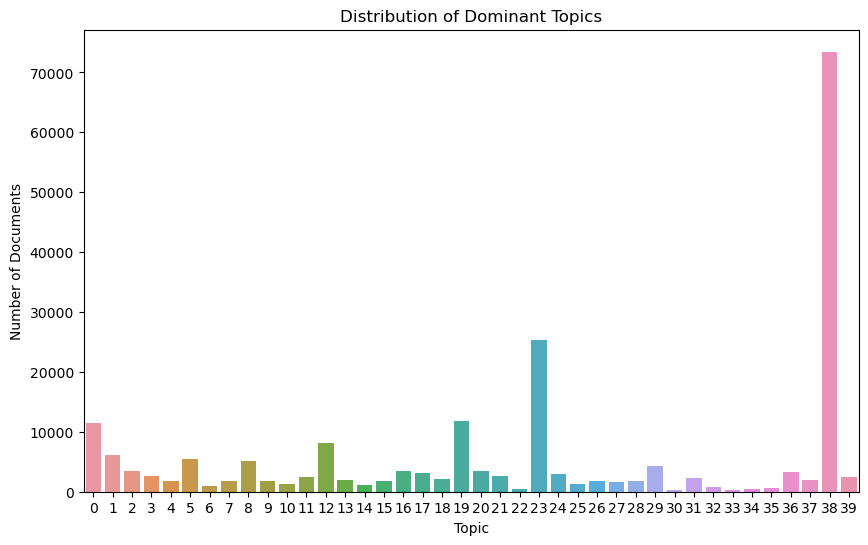

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of dominant topics
plt.figure(figsize=(10,6))
sns.countplot(x='dominant_topic', data=processed_df)
plt.title('Distribution of Dominant Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.show()


In [ ]:
import pyLDAvis.gensim_models
import pyLDAvis

# Prepare visualization for the first LDA model
lda_visualization = pyLDAvis.gensim_models.prepare(lda_models[0], corpus, dictionary)
pyLDAvis.display(lda_visualization)

# Save the visualization to an HTML file in folder B:
#pyLDAvis.save_html(lda_visualization, '/Users/niklaselsasser/Code/bug-free-fishstick/visuals/VSC5_lda_visualization.html')

KeyboardInterrupt: 

# Evaluating topics against values of category

In [ ]:
def get_top_words_per_topic(lda_model, num_words=10):
    top_words_per_topic = {}
    for topic_id in range(lda_model.num_topics):
        top_words = lda_model.show_topic(topic_id, topn=num_words)
        top_words_per_topic[topic_id] = [word for word, _ in top_words]
    return top_words_per_topic

# Get top words for the first LDA model as an example
top_words = get_top_words_per_topic(lda_models[0], num_words=10)


In [ ]:
print(len(corpus))  # Should be equal to the number of rows in processed_df
print(processed_df.shape[0])  # Number of rows in processed_df

209516
209516


In [ ]:
# Define the function to assign dominant topics
def assign_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for bow in corpus:
        topic_probs = lda_model.get_document_topics(bow, minimum_probability=0)
        dominant_topic = sorted(topic_probs, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Step to assign dominant topics
dominant_topics = assign_dominant_topic(lda_models[0], corpus)

# Use .loc to avoid SettingWithCopyWarning
processed_df.loc[:, 'dominant_topic'] = dominant_topics

In [ ]:
# Checking the DataFrame after assigning dominant topics
print(processed_df.head())

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description  \
0  Health experts said it is too early to predict...   
1  He was subdued by passengers and crew when he ...   
2  "Until you have a dog you don't understand wha...   
3  "Accidentally put grown-up toothpaste on my to...   
4  Amy Cooper accused investment firm Franklin Te...   

                                      processed_text  headline_word_count  \
0  [million, american, roll, sleeve, omicrontarge...                   11   
1  [american, airline, flyer, charged, banned, li...                   13   
2  [funniest, tweet, cat, dog

In [ ]:
def map_topics_to_categories(processed_df):
    topic_category_mapping = {}
    for topic in processed_df['dominant_topic'].unique():
        # Get documents assigned to the topic
        topic_docs = processed_df[processed_df['dominant_topic'] == topic]
        # Find the most common category among these documents
        if not topic_docs.empty:
            most_common_category = topic_docs['category'].mode()[0]
            topic_category_mapping[topic] = most_common_category
    return topic_category_mapping

# Create the mapping
topic_category_mapping = map_topics_to_categories(processed_df)
print("Topic to Category Mapping:")
print(topic_category_mapping)


Topic to Category Mapping:
{9: 'POLITICS', 6: 'WELLNESS', 0: 'POLITICS', 4: 'ENTERTAINMENT', 5: 'POLITICS', 2: 'POLITICS', 7: 'POLITICS', 1: 'POLITICS', 8: 'POLITICS', 3: 'POLITICS'}


In [ ]:
def assign_predicted_category(processed_df, topic_category_mapping):
    processed_df['predicted_category'] = processed_df['dominant_topic'].map(topic_category_mapping)
    return processed_df

# Assign predicted categories
processed_df = assign_predicted_category(processed_df, topic_category_mapping)


/var/folders/3t/mgckmfnn5p745wd8_80ywb0c0000gn/T/ipykernel_1277/1491127418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df.loc['predicted_category'] = processed_df['dominant_topic'].map(topic_category_mapping)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Remove any rows where 'predicted_category' is NaN
evaluation_df = processed_df.dropna(subset=['predicted_category'])

# Actual and predicted categories
y_true = evaluation_df['category']
y_pred = evaluation_df['predicted_category']

# Calculate metrics
print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print(f"Accuracy Score: {accuracy_score(y_true, y_pred):.4f}")


Classification Report:


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          ARTS       0.00      0.00      0.00      1509
ARTS & CULTURE       0.00      0.00      0.00      1339
  BLACK VOICES       0.00      0.00      0.00      4583
      BUSINESS       0.00      0.00      0.00      5991
       COLLEGE       0.00      0.00      0.00      1144
        COMEDY       0.00      0.00      0.00      5398
         CRIME       0.00      0.00      0.00      3562
CULTURE & ARTS       0.00      0.00      0.00      1074
       DIVORCE       0.00      0.00      0.00      3426
     EDUCATION       0.00      0.00      0.00      1014
 ENTERTAINMENT       0.11      0.07      0.09     17361
   ENVIRONMENT       0.00      0.00      0.00      1444
         FIFTY       0.00      0.00      0.00      1400
  FOOD & DRINK       0.00      0.00      0.00      6340
     GOOD NEWS       0.00      0.00      0.00      1398
         GREEN       0.00      0.00      0.00      2622
HEALTHY LIVING       0.00      0.00      0.00  

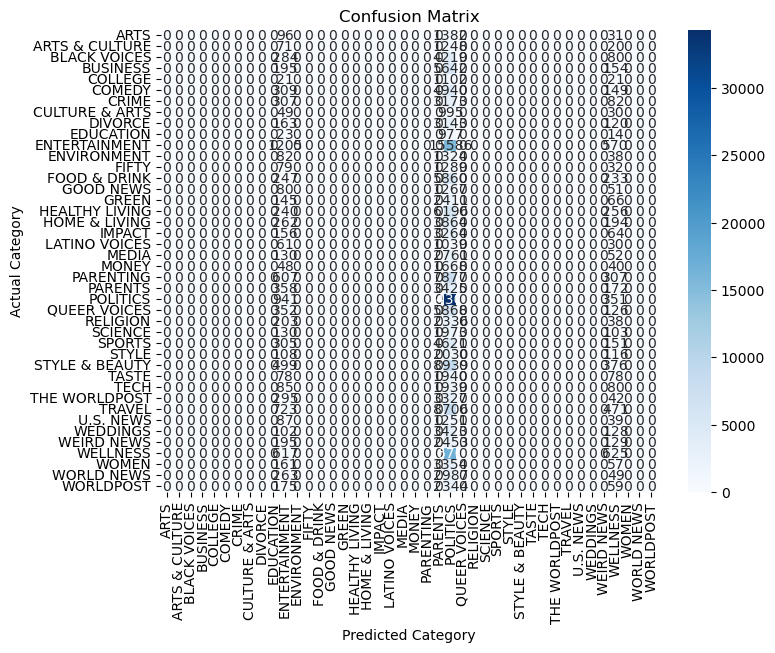

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels, save_path=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual Category')
    plt.xlabel('Predicted Category')
    plt.title('Confusion Matrix')
    if save_path:
        plt.savefig(save_path, format='png')
    plt.show()

# Get list of unique categories
categories = sorted(processed_df['category'].unique())

# Plot and save confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=categories, save_path='/Users/niklaselsasser/Code/bug-free-fishstick/visuals/VSC5_confusion_matrix.png')

# further visualization

In [ ]:
processed_df.head(5)

,headline,category,short_description,processed_text,headline_word_count,short_description_word_count,processed_text_word_count,dominant_topic,predicted_category
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"[million, american, roll, sleeve, omicrontarge...",11,29,22,9,POLITICS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,"[american, airline, flyer, charged, banned, li...",13,28,22,6,WELLNESS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...","[funniest, tweet, cat, dog, week, sept, dog, d...",13,12,11,0,POLITICS
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...","[funniest, tweet, parent, week, sept, accident...",9,25,20,4,ENTERTAINMENT
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,"[woman, called, cop, black, birdwatcher, loses...",11,25,25,5,POLITICS


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Assuming 'processed_df' already contains 'headline', 'category', and 'dominant_topic'

# Add a column for the top words of the dominant topic for each document
def get_top_words_for_topic(lda_model, topic_id, num_words=5):
    return ", ".join([word for word, _ in lda_model.show_topic(topic_id, topn=num_words)])

# Add the top words for the dominant topic to the dataframe
processed_df['generated_topic'] = processed_df['dominant_topic'].apply(
    lambda topic_id: get_top_words_for_topic(lda_models[0], topic_id, num_words=5)
)

/var/folders/3t/mgckmfnn5p745wd8_80ywb0c0000gn/T/ipykernel_1277/14035858.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['generated_topic'] = processed_df['dominant_topic'].apply(


In [ ]:
# Select columns for display
df_visual = processed_df[['headline', 'short_description', 'category', 'predicted_category']]

# Display a simple DataFrame table
df_visual.head(10)

,headline,short_description,category,predicted_category
0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...,U.S. NEWS,POLITICS
1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...,U.S. NEWS,WELLNESS
2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha...",COMEDY,POLITICS
3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to...",PARENTING,ENTERTAINMENT
4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...,U.S. NEWS,POLITICS
5,Cleaner Was Dead In Belk Bathroom For 4 Days B...,The 63-year-old woman was seen working at the ...,U.S. NEWS,POLITICS
6,Reporter Gets Adorable Surprise From Her Boyfr...,"""Who's that behind you?"" an anchor for New Yor...",U.S. NEWS,POLITICS
7,Puerto Ricans Desperate For Water After Hurric...,More than half a million people remained witho...,WORLD NEWS,POLITICS
8,How A New Documentary Captures The Complexity ...,"In ""Mija,"" director Isabel Castro combined mus...",CULTURE & ARTS,POLITICS
9,Biden At UN To Call Russian War An Affront To ...,White House officials say the crux of the pres...,WORLD NEWS,POLITICS


In [ ]:
df_visual.to_csv('/Users/niklaselsasser/Code/bug-free-fishstick/visuals/VSC5_headline_category_generated_topic.csv', index=False)

In [ ]:
# Create a new column to indicate matches
df.loc[:, 'match'] = df['category'] == df['predicted_category']

# Group by category and count matches
match_counts = df.groupby('category')['match'].sum().reset_index()
match_counts.columns = ['category', 'match_count']

# Count total entries per category
category_counts = df['category'].value_counts(normalize=False).reset_index()
category_counts.columns = ['category', 'total_count']

# Merge match counts with total counts
comparison = pd.merge(match_counts, category_counts, on='category')

# Calculate match percentage
comparison['match_percentage'] = (comparison['match_count'] / comparison['total_count']) * 100

# Split into matched and no-match categories
matched_categories = comparison[comparison['match_count'] > 0]
no_match_categories = comparison[comparison['match_count'] == 0]

# Sort matched categories by match percentage (descending)
matched_categories_sorted = matched_categories.sort_values(by='match_percentage', ascending=False)

# Display matched categories
print("Matched Categories (Sorted by Match Percentage):")
print(matched_categories_sorted[['category', 'total_count', 'match_count', 'match_percentage']])

# Display no match categories
print("\nCategories with No Match:")
print(no_match_categories[['category', 'total_count', 'match_count', 'match_percentage']])

Matched Categories (Sorted by Match Percentage):
         category  total_count  match_count  match_percentage
24       POLITICS        35601        34309         96.370888
10  ENTERTAINMENT        17361         1205          6.940844
38       WELLNESS        17945          625          3.482864

Categories with No Match:
          category  total_count  match_count  match_percentage
0             ARTS         1509            0               0.0
1   ARTS & CULTURE         1339            0               0.0
2     BLACK VOICES         4583            0               0.0
3         BUSINESS         5991            0               0.0
4          COLLEGE         1144            0               0.0
5           COMEDY         5398            0               0.0
6            CRIME         3562            0               0.0
7   CULTURE & ARTS         1074            0               0.0
8          DIVORCE         3426            0               0.0
9        EDUCATION         1014            0  

/var/folders/3t/mgckmfnn5p745wd8_80ywb0c0000gn/T/ipykernel_1277/2782885632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'match'] = df['category'] == df['predicted_category']


In [ ]:
run_details = pd.read_csv('visuals/VSC5_run_data.csv')

# Extract run numbers from the model names
coherence_df['Run'] = coherence_df['Model'].str.extract('(\d+)').astype(int)

# Merge the DataFrames on the 'Run' column
merged_df = pd.merge(run_details, coherence_df[['Run', 'Coherence Score']], on='Run', how='left')

# Save the merged DataFrame to a CSV file
merged_df.to_csv('visuals/VSC5_run_details_with_coherence.csv', index=False)
merged_df.head(5)


<>:4: DeprecationWarning: invalid escape sequence '\d'
<>:4: DeprecationWarning: invalid escape sequence '\d'
/var/folders/3t/mgckmfnn5p745wd8_80ywb0c0000gn/T/ipykernel_1277/2665748796.py:4: DeprecationWarning: invalid escape sequence '\d'
  coherence_df['Run'] = coherence_df['Model'].str.extract('(\d+)').astype(int)


,Run,Start Time,End Time,Duration (minutes),Coherence Score
0,1,2024-10-14 14:14:43,2024-10-14 14:14:46,0.054248,0.298383
1,2,2024-10-14 14:14:46,2024-10-14 14:14:50,0.055266,0.313973
2,3,2024-10-14 14:14:50,2024-10-14 14:14:53,0.061482,0.289475
3,4,2024-10-14 14:14:53,2024-10-14 14:14:57,0.059552,0.286153
